In [0]:
!dir

In [0]:
!pip install pytorch_pretrained_bert

In [0]:
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from read_data import Embeddings
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import torch

In [3]:
df = pd.read_excel('./CONCS_FEATS_concstats_brm.xlsx')
embeds = Embeddings()

100%|██████████| 407873900/407873900 [00:15<00:00, 26919399.78B/s]


In [0]:
concepts = list(df[["Concept","Feature"]].groupby("Concept").groups.keys())
features = list(df[["Concept","Feature"]].groupby("Concept")["Feature"].apply(list))

dict_features = []
for feat in features:
    dict_features += [dict.fromkeys(feat, True)]

In [0]:
dv = DictVectorizer(sparse=False)
Y = dv.fit_transform(dict_features)
Y = torch.tensor(Y).double()

In [0]:
embeddings = []
for con in concepts:
    em = embeds.getEmbeddings(con.split("_")[0]).tolist()
    embeddings.append(em)

embeddings = torch.tensor(embeddings)

In [0]:
def sigmoid(x): return 1/(1 + (-x).exp())

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(12 * 768, 300)
        self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100, 2526)

    def forward(self, x):
        x = x.view(-1, 12 * 768)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = torch.sigmoid(x)
        # x = F.softmax(x)
        # F.log_softmax(x)
        return x

In [237]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))
net = Net()
net.to(device)
net.double()
torch.autograd.set_detect_anomaly(True)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.2)
pos_weight = (torch.ones(Y.shape[1])*3).double()
criterion = nn.BCELoss(weight=pos_weight)
criterion.to(device)

cuda:0
Tesla P100-PCIE-16GB


BCELoss()

In [0]:
def BCE_mod(pred, label):
  eps = 1e-12
  # print(pred)
  cl = pred.clone()  
  cl[cl >= 0.5] = 1
  cl[cl < 0.5] = 0
  # print(cl.shape)
  pred_id = np.where(np.asarray(label.flatten().tolist()) == 1)[0]
  
  ownloss = cl-label  
  ownloss[ownloss == -1] = 1
  # ownloss=-(label*pred.clamp(min=eps).log()+(1-label)*(1-pred).clamp(min=eps).log()).mean()  
  return ownloss.sum()/ownloss.shape[1]

In [0]:
embeddings = embeddings.double()
trainX = embeddings[:449]
devX = embeddings[450:499]
testX = embeddings[500:]

trainY = Y[:449]
devY = Y[450:499]
testY = Y[500:]

In [239]:
epochs = 200
batch_size = 8
run_loss = []
batches = int(len(trainX)/batch_size)
print(batches)
for epoch in range(epochs):
    for batch_idx in range(batches):
        start = batch_size * batch_idx
        end = batch_size * (batch_idx + 1)
        # data, target = Variable(trainX[start:end]), Variable(trainY[start:end])​
        data, target = Variable(trainX[start:end]), Variable(trainY[start:end])
        if torch.cuda.is_available():
            data, target = data.to(device), target.to(device)
        # print(data.shape, target.shape)
        # resize data from (batch_size, 1, 28, 28) to (batch_size, 28*28)
        # data = data.view(-1, 12*768)
        optimizer.zero_grad()
        net_out = net(data)
        # print(net_out)
        # cl_out = net_out.clone()    
        # cl_out[cl_out < 0.5] = 0
        # cl_out[cl_out >= 0.5] = 1        
        loss = criterion(net_out.reshape((-1,2526)), target.reshape((-1,2526)))
        loss.backward()
        optimizer.step()
    if epoch%2 == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, start , len(trainX),
                        100. * batch_idx / len(trainX), loss.data))
    run_loss.append(loss.item())

56
Train Epoch: 0 [440/449 (12%)]	Loss: 2.081525
Train Epoch: 2 [440/449 (12%)]	Loss: 2.077747
Train Epoch: 4 [440/449 (12%)]	Loss: 2.074954
Train Epoch: 6 [440/449 (12%)]	Loss: 2.072405
Train Epoch: 8 [440/449 (12%)]	Loss: 2.069994
Train Epoch: 10 [440/449 (12%)]	Loss: 2.067652
Train Epoch: 12 [440/449 (12%)]	Loss: 2.065330
Train Epoch: 14 [440/449 (12%)]	Loss: 2.063022
Train Epoch: 16 [440/449 (12%)]	Loss: 2.060683
Train Epoch: 18 [440/449 (12%)]	Loss: 2.058263
Train Epoch: 20 [440/449 (12%)]	Loss: 2.055712
Train Epoch: 22 [440/449 (12%)]	Loss: 2.053003
Train Epoch: 24 [440/449 (12%)]	Loss: 2.050084
Train Epoch: 26 [440/449 (12%)]	Loss: 2.046929
Train Epoch: 28 [440/449 (12%)]	Loss: 2.043507
Train Epoch: 30 [440/449 (12%)]	Loss: 2.039786
Train Epoch: 32 [440/449 (12%)]	Loss: 2.035736
Train Epoch: 34 [440/449 (12%)]	Loss: 2.031332
Train Epoch: 36 [440/449 (12%)]	Loss: 2.026558
Train Epoch: 38 [440/449 (12%)]	Loss: 2.021378
Train Epoch: 40 [440/449 (12%)]	Loss: 2.015757
Train Epoch: 42

In [241]:
print("Target:",np.where(np.asarray(target[0].tolist()) == 1.0000)[0])
print("Max in net_out:",max(np.asarray(net_out[0].tolist())))
print("net_out where 1:",np.where(np.asarray(net_out[0].tolist()) >= 0.1)[0])
print("net_out", np.argsort(np.asarray(net_out[0].tolist()))[:15])

Target: [ 375 1251 1260 1592 1598 1617 1765 1817 2226 2280 2351 2378]
Max in net_out: 0.22671785373336362
net_out where 1: [ 151 1239 1293 1299 1355 1378 1592 1617]
net_out [1709 1287  167 2444 1593  971 2501 1146  415 1826  192 2042  510 1511
 1297]


In [0]:
import matplotlib.pyplot as plt

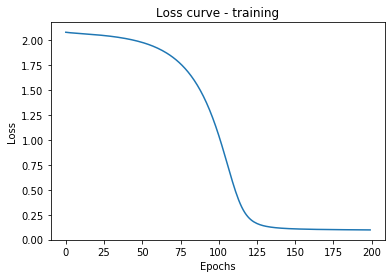

In [240]:
plt.title("Loss curve - training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(list(range(0,epochs)), run_loss)

In [270]:
test_loss = 0
correct = 0
precision = 0
threshold = 0.99
recall = 0

with torch.no_grad():
    data, target = Variable(devX), Variable(devY)
    if torch.cuda.is_available():
        data, target = data.to(device), target.to(device)

    net_out = net(data)
    test_loss += criterion(net_out, target).data
    out = net_out.data
    x = out.clone()
    # print(out.min(axis=1))    
    out[out > 0.12] = 1
    out[out <= 0.12] = 0

for idx, act in enumerate(target):
    pred = out[idx]
    
    match = sum((pred == act) * 1)

    if match.tolist()/2526 >= threshold:
        correct += 1    

    idx_pred = np.where(np.array(out[idx].tolist()) == 1)
    idx_act = np.where(np.array(target[idx].tolist()) == 1)

    if idx == 35:
      print(concepts[idx])
      print(np.asarray(dv.get_feature_names())[idx_pred])
      print(np.asarray(dv.get_feature_names())[idx_act])

    tn_fp = out[idx].sum()
    tn_tp = target[idx].sum()

    precision += len(np.intersect1d(idx_act, idx_pred))/tn_fp
    recall += len(np.intersect1d(idx_act, idx_pred))/tn_tp


print("Accuracy:", correct/len(devX))
print("Precision:", precision/len(devX))
print("Recall:", recall/len(devX))


bedroom
['an_animal' 'different_colours' 'is_brown' 'is_edible' 'is_large'
 'is_long' 'is_round' 'is_small' 'is_white' 'made_of_metal' 'made_of_wood']
['clothing' 'different_colours' 'eg_-_bow' 'has_a_knot' 'has_patterns'
 'is_businesslike' 'is_formal' 'is_long' 'is_thin' 'made_of_material'
 'made_of_silk' 'worn_around_neck' 'worn_by_men' 'worn_with_suits']
Accuracy: 0.9387755102040817
Precision: tensor(0.1709, device='cuda:0', dtype=torch.float64)
Recall: tensor(0.1089, device='cuda:0', dtype=torch.float64)


In [249]:
print(max(x[0].tolist()))
print(min(x[0].tolist()))
print((max(x[0].tolist())-min(x[0].tolist()))/2)
a = (x.max()-x.min())/2
print(a.item())

0.244757244019339
9.306159279937718e-10
0.12237862154436153
0.13491462261700765


In [260]:
print(concepts[idx])
print(np.asarray(dv.get_feature_names())[idx_pred])
print(np.asarray(dv.get_feature_names())[idx_act])

blouse
['an_animal' 'is_edible' 'is_large' 'is_small' 'made_of_metal'
 'made_of_wood']
['found_in_cafeterias' 'is_flat' 'is_rectangular' 'is_round' 'is_square'
 'made_of_metal' 'made_of_plastic' 'used_by_waitresses'
 'used_for_carrying_drinks' 'used_for_carrying_things' 'used_for_food'
 'used_for_holding_things']


In [0]:
label = torch.tensor([1,0,0,0,1,0,0], dtype=torch.float64)
pred = torch.tensor([0,0,1,0,1,0,0], dtype=torch.float64)
eps = 1e-12
ownloss=-(label*pred.clamp(min=eps).log()+(1-label)*(1-pred).clamp(min=eps).log()).mean()
print(ownloss)

In [0]:
ans = pred-label
ans[ans == -1] = 1
print("LOSS:", ans.sum()/ans.shape[0])
# number of ones are the incorrect predictions

In [0]:
output = Variable(torch.randn(10, 120).float())
target = Variable(label.uniform_(0, 7).long())